In [1]:
# importing related packages

import pandas as pd
import numpy as np

import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn import linear_model
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

In [2]:
songs = pd.read_csv('../data/SpotifyCleaned.csv')

# Exploratory Analysis

In [3]:
songs.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Opera,Giuseppe Verdi,"Stiffelio, Act III: Ei fugge! … Lina, pensai c...",7EsKYeHtTc4H4xWiTqSVZA,21,0.986,0.313,490867,0.23100,0.000431,C#,0.0964,-14.287,Major,0.0547,86.001,4/4,0.0886
1,Opera,Giacomo Puccini,Madama Butterfly / Act 1: ... E soffitto e pareti,7MfmRBvqaW0I6UTxXnad8p,18,0.972,0.360,176797,0.20100,0.028000,D#,0.1330,-19.794,Major,0.0581,131.798,4/4,0.3690
2,Opera,Giacomo Puccini,"Turandot / Act 2: Gloria, gloria, o vincitore",7pBo1GDhIysyUMFXiDVoON,10,0.935,0.168,266184,0.47000,0.020400,C,0.3630,-8.415,Major,0.0383,75.126,3/4,0.0696
3,Opera,Giuseppe Verdi,"Rigoletto, Act IV: Venti scudi hai tu detto?",02mvYZX5aKNzdqEo6jF20m,17,0.961,0.250,288573,0.00605,0.000000,D,0.1200,-33.440,Major,0.0480,76.493,4/4,0.0380
4,Opera,Giuseppe Verdi,"Don Carlo / Act 4: ""Ella giammai m'amò!""",03TW0jwGMGhUabAjOpB1T9,19,0.985,0.142,629760,0.05800,0.146000,D,0.0969,-23.625,Major,0.0493,172.935,4/4,0.0382


In [4]:
songs['genre'].unique()

array(['Opera', 'A Capella', 'Alternative', 'Blues', 'Dance', 'Pop',
       'Electronic', 'R&B', 'Folk', 'Rap', 'Classical', 'Reggae',
       'Hip-Hop', 'Comedy', 'Country', 'Reggaeton', 'Ska', 'Indie',
       'Rock', 'Soul', 'Soundtrack', 'Jazz', 'World', 'Movie'],
      dtype=object)

In [5]:
len(songs) # there are 153685 songs (observation) we are working with

153685

In [6]:
songs.groupby(by = 'popularity').size()

popularity
0      3186
1       704
2       598
3       610
4       649
       ... 
96        4
97        6
98        1
99        2
100       1
Length: 101, dtype: int64

# Data Preprocessing

In [7]:
songs.columns

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

In [8]:
songs.columns.to_series().groupby(songs.dtypes).groups

{int64: ['popularity', 'duration_ms'], float64: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'], object: ['genre', 'artist_name', 'track_name', 'track_id', 'key', 'mode', 'time_signature']}

In [9]:
## Map key and artist name to a categorical value like dictionary

## Extract to-be-hashed values for reference later

unhashed = pd.DataFrame({'genre': songs['genre'],
                         'artist_name': songs['artist_name'],
                         'key': songs['key'],
                         'mode': songs['mode'],
                         'time_signature': songs['time_signature']}) ## Add other categorical values here if need to be hashed

## Any Categorical Data Can be converted, just enter it under this section (Automize if you wish)
songs['genre'] = songs['genre'].astype('category')
songs['artist_name'] = songs['artist_name'].astype('category')
songs['key'] = songs['key'].astype('category')
songs['mode'] = songs['mode'].astype('category')
songs['time_signature'] = songs['time_signature'].astype('category')

cat_columns = songs.select_dtypes(['category']).columns

songs[cat_columns] = songs[cat_columns].apply(lambda x: x.cat.codes)

# print(songs.head()) # Altered DataSet

print(songs[cat_columns].head()) # Altered Columns
print(unhashed.head()) #Original Columns

   genre  artist_name  key  mode  time_signature
0     13         4398    4     0               3
1     13         4343    6     0               3
2     13         4343    3     0               2
3     13         4398    5     0               3
4     13         4398    5     0               3
   genre      artist_name key   mode time_signature
0  Opera   Giuseppe Verdi  C#  Major            4/4
1  Opera  Giacomo Puccini  D#  Major            4/4
2  Opera  Giacomo Puccini   C  Major            3/4
3  Opera   Giuseppe Verdi   D  Major            4/4
4  Opera   Giuseppe Verdi   D  Major            4/4


# Baseline Multiple Linear Regression Models

## Predicting Popularity by Song Features Across All Genres

### Feature Selection

In [10]:
predictors = ['acousticness', 'danceability', 'duration_ms', 'energy',
              'instrumentalness', 'key', 'liveness', 'mode',
              'speechiness', 'tempo', 'time_signature', 'valence'] #removing loudness

In [11]:
x = songs[predictors]

y = songs['popularity']

In [12]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
#Select top 2 features based on mutual info regression
selector = SelectKBest(mutual_info_regression, k =4)
selector.fit(x, y)
x.columns[selector.get_support()]

Index(['acousticness', 'danceability', 'energy', 'speechiness'], dtype='object')

In [13]:
best_predictors = ['acousticness', 'danceability', 'energy', 'speechiness'] # they don't improve accuracy or anything, but cool to know

### Splitting Data for Train/Test

In [14]:
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 131)

### Creating and Testing Multiple Linear Regression Model

In [15]:
LR = linear_model.LinearRegression()
LR.fit(x_train, y_train)

LinearRegression()

In [16]:
y_prediction_train =  LR.predict(x_train)
y_prediction_train

array([27.23840303, 25.78888103, 33.17252129, ..., 40.11523565,
       45.2273652 , 35.2485157 ])

In [17]:
score=r2_score(y_train,y_prediction_train)
print('R2 Score:',score)
print('MSE',mean_squared_error(y_train,y_prediction_train))
print('RMSE',np.sqrt(mean_squared_error(y_train,y_prediction_train)))

R2 Score: 0.23362538922121023
MSE 224.0802228407045
RMSE 14.969309364185927


In [18]:
y_prediction =  LR.predict(x_test)
y_prediction

array([46.32840539, 26.32452645, 33.31869736, ..., 43.55380545,
       48.17738233, 37.49011013])

In [19]:
# predicting the accuracy score
score=r2_score(y_test,y_prediction)
print('R2 Score:',score)
print('MSE',mean_squared_error(y_test,y_prediction))
print('RMSE',np.sqrt(mean_squared_error(y_test,y_prediction)))

R2 Score: 0.23920140926332245
MSE 224.18957506291093
RMSE 14.972961466019704


Scores are pretty low...

## Predicting Popularity by Song Features in Each Individual Genre

In [20]:
def genre_MLR_score(genre, songs, unhashed, predictors):
    # params:
        # genre: string representing genre as listed in the dataset to analyze
        # songs: total song dataset
    
    genre_indices = unhashed[unhashed['genre'] == genre].index.values.tolist()
    genre_songs = songs.iloc[genre_indices]
    
    x = genre_songs[predictors] 
    y = genre_songs['popularity']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 131)
    
    LR = linear_model.LinearRegression()
    LR.fit(x_train, y_train)
    
    y_prediction_train = LR.predict(x_train)
    y_prediction =  LR.predict(x_test)
    
    score_train = r2_score(y_train,y_prediction_train)
    
    score=r2_score(y_test,y_prediction)
    
    genre_df = {'Genre': genre, 'Count': len(genre_songs),
                'R2_train': score_train, 'MSE_train': mean_squared_error(y_train,y_prediction_train), 'RMSE_train': np.sqrt(mean_squared_error(y_train,y_prediction_train)),
                'R2': score, 'MSE': mean_squared_error(y_test,y_prediction), 'RMSE': np.sqrt(mean_squared_error(y_test,y_prediction))}
    
    return genre_df

In [21]:
genres = list(unhashed.genre.unique())
genre_scores_df = pd.DataFrame()

for genre in genres:
    genre_df = genre_MLR_score(genre, songs, unhashed, predictors)
    genre_scores_df = genre_scores_df.append(genre_df, ignore_index = True)

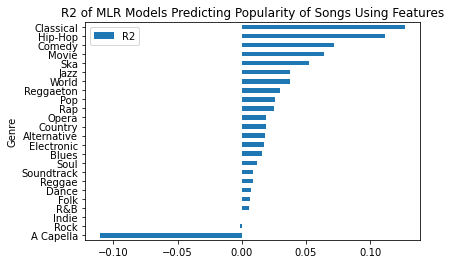

In [22]:
genre_scores_df_R2 = genre_scores_df.sort_values(by = 'R2', ascending = True)
ax = genre_scores_df_R2.plot.barh(x='Genre', y='R2', rot=0, title = 'R2 of MLR Models Predicting Popularity of Songs Using Features')

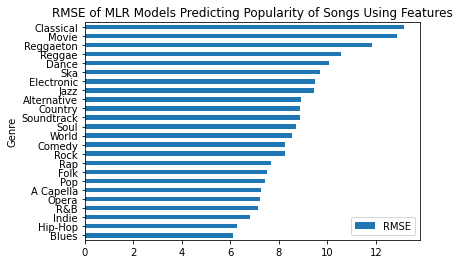

In [23]:
genre_scores_df_RMSE = genre_scores_df.sort_values(by = 'RMSE', ascending = True)
ax = genre_scores_df_RMSE.plot.barh(x='Genre', y='RMSE', rot=0, title = 'RMSE of MLR Models Predicting Popularity of Songs Using Features')

In [24]:
# plotly of same thing above; not working on my machine
fig = px.bar(genre_scores_df_R2, y="Genre", x='R2', orientation='h', title='R2 of MLR Models Predicting Popularity of Songs Using Features')